Melika Ahmadi Ranjbar 97521036

---
Homework 11


#Question 2

In [41]:
import re
import nltk
import itertools
import numpy as np
from tqdm import tqdm
from scipy import sparse
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Input, Model

nltk.download('reuters')
from nltk.corpus import reuters


[nltk_data] Downloading package reuters to /root/nltk_data...


In [42]:
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

In [54]:
# Create Input
# Crude
input = []
for field in reuters.fileids('crude'):
    input.append(field)
# The first One Hundred Files
input = input[0:100]

texts = []
for files in input:
    file_words = reuters.words(files)
    output = " ".join(file_words)
    texts.append(output)

print(len(texts))

100


In [36]:
def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    
def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]       

In [55]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

In [56]:
# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

56416it [00:01, 34108.88it/s]


In [57]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000
    )

# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

Train on 56416 samples
Epoch 1/1000
56416/56416 [==============================] - 2s 44us/sample - loss: 7.7917
Epoch 2/1000
56416/56416 [==============================] - 2s 35us/sample - loss: 7.3422
Epoch 3/1000
56416/56416 [==============================] - 2s 34us/sample - loss: 6.8788
Epoch 4/1000
56416/56416 [==============================] - 2s 34us/sample - loss: 6.6750
Epoch 5/1000
56416/56416 [==============================] - 2s 34us/sample - loss: 6.6296
Epoch 6/1000
56416/56416 [==============================] - 2s 35us/sample - loss: 6.6157
Epoch 7/1000
56416/56416 [==============================] - 2s 35us/sample - loss: 6.6080
Epoch 8/1000
56416/56416 [==============================] - 2s 34us/sample - loss: 6.6028
Epoch 9/1000
56416/56416 [==============================] - 2s 34us/sample - loss: 6.5990
Epoch 10/1000
56416/56416 [==============================] - 2s 34us/sample - loss: 6.5959
Epoch 11/1000
56416/56416 [==============================] - 2s 35us/sample 

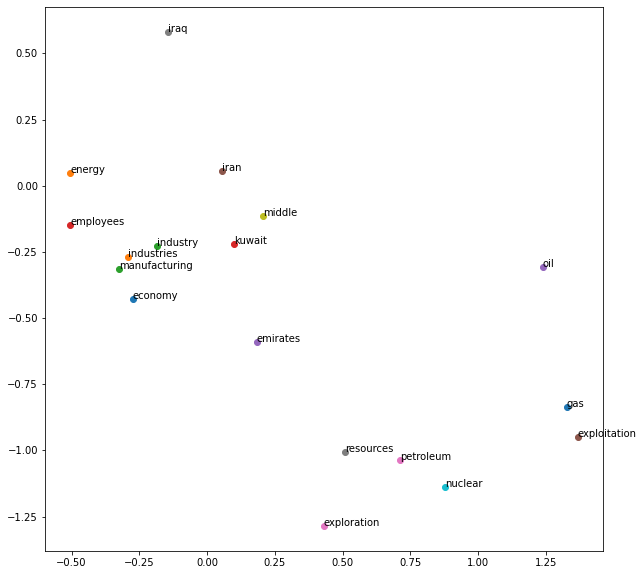

In [59]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
words = ['gas', 'energy', 'industry', 'kuwait', 'oil', 'iran', 'petroleum', 'iraq',
'middle', 'nuclear', 'economy', 'industries', 'manufacturing', 'employees',
'emirates', 'exploitation', 'exploration', 'resources']
for word in words:
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       

In [66]:
# Finad Similarities
similarities = find_similar('iran', embedding_dict, 5)
print(similarities)

similarities = find_similar('nuclear', embedding_dict, 5)
print(similarities)

similarities = find_similar('crude', embedding_dict, 5)
print(similarities)

[('nations', 0.004070975), ('deposits', 0.01005239), ('marketer', 0.03207974), ('seven', 0.04138999), ('maintain', 0.047143772)]
[('debt', 0.115254775), ('baker', 0.12601924), ('coast', 0.12992464), ('contain', 0.13754106), ('eni', 0.14494514)]
[('oilfields', 0.03757054), ('feet', 0.080157235), ('posting', 0.14351907), ('jungle', 0.17233506), ('reduces', 0.17868893)]


#Question 3

In [1]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras import backend as K
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils import shuffle

tf.compat.v1.disable_eager_execution()

In [2]:
# Import Data
(TrainData, Label), (TestData, TestLabel) = mnist.load_data()

# Shuffle
TrainData, Label = shuffle(TrainData, Label)

# Print 
print('Train Data Dimension', TrainData.shape)
print('Test Data Dimension', TestData.shape)


11501568/11490434 [==============================] - 0s 0us/step
Train Data Dimension (60000, 28, 28)
Test Data Dimension (10000, 28, 28)


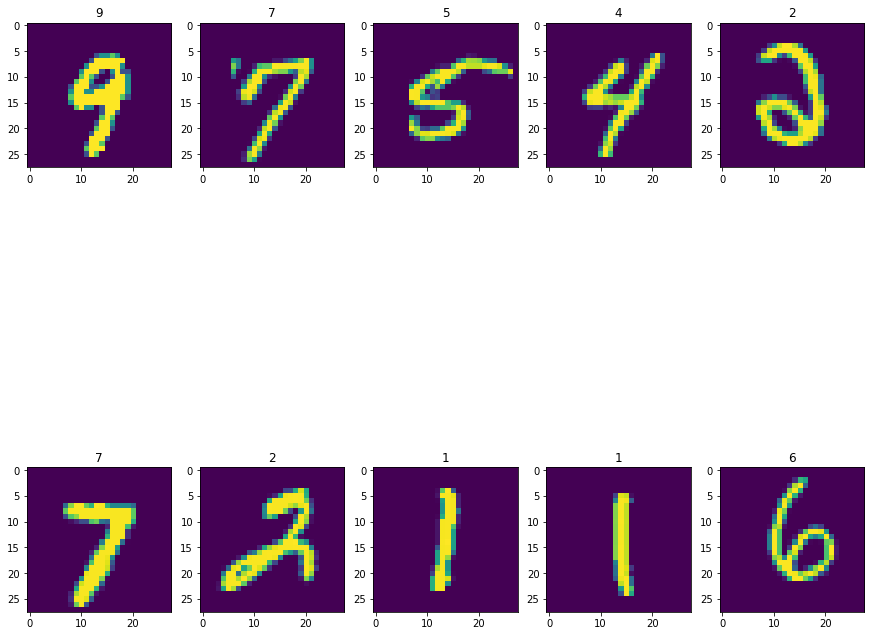

In [3]:
# Plot
Images = np.array(TrainData)
Rows = 2
Columns = 5
plt.figure (figsize = (15, 15))
for i in range(10):
    sp = plt.subplot(Rows, Columns, i + 1)
    plt.imshow(Images[i])
    plt.title(Label[i])
plt.show()

In [4]:
# Reshape
TrainData = TrainData.reshape(60000, 28, 28, 1)  
TestData = TestData.reshape(10000, 28, 28, 1)  

TrainData = np.true_divide(TrainData, 255)
TestData = np.true_divide(TestData, 255)

# Categorical
Label = tf.keras.utils.to_categorical(Label, num_classes=10)
TestLabel = tf.keras.utils.to_categorical(TestLabel, num_classes=10)


In [5]:
def CreateModel():
    Model = Sequential()
    Model.add(layers.InputLayer(TrainData[0].shape))
    Model.add(layers.Conv2D(32, (3, 3), padding='same', activation='ReLU'))
    Model.add(layers.MaxPooling2D((2, 2)))
    Model.add(layers.Conv2D(64, (3, 3), padding='same', activation='ReLU'))
    Model.add(layers.MaxPooling2D((2, 2)))   
    Model.add(layers.Conv2D(64, (3, 3), padding='same', activation='ReLU'))
    Model.add(layers.MaxPooling2D((2, 2)))
    Model.add(layers.Flatten())
    Model.add(layers.Dense(128, activation='ReLU'))
    Model.add(layers.Dense(10, activation='Softmax'))

    Optimizer = 'Adam'
    Loss = 'categorical_crossentropy'
    Model.compile(Optimizer, Loss, metrics=['accuracy'])

    return Model

In [6]:
Model = CreateModel()
Epochs = 15
BatchSize = 64
Model.fit(TrainData, Label, BatchSize, Epochs, validation_data=(TestData, TestLabel))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9494

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 23s 377us/sample - loss: 0.1672 - accuracy: 0.9494 - val_loss: 0.0501 - val_accuracy: 0.9849
Epoch 2/15
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0461 - accuracy: 0.9857 - val_loss: 0.0356 - val_accuracy: 0.9887
Epoch 3/15
60000/60000 [==============================] - 8s 137us/sample - loss: 0.0333 - accuracy: 0.9890 - val_loss: 0.0303 - val_accuracy: 0.9896
Epoch 4/15
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0248 - accuracy: 0.9921 - val_loss: 0.0228 - val_accuracy: 0.9923
Epoch 5/15
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0213 - accuracy: 0.9930 - val_loss: 0.0340 - val_accuracy: 0.9904
Epoch 6/15
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0328 - val_accuracy: 0.9905
Epoch 7/15
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0145 - accuracy: 0.9949 -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

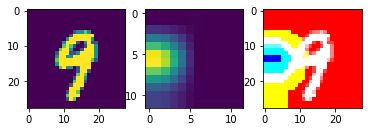

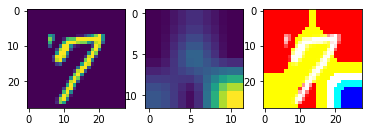

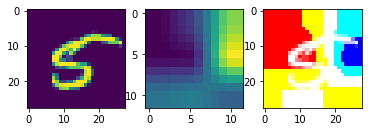

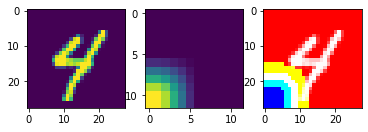

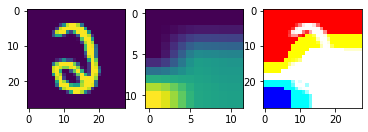

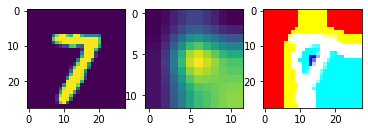

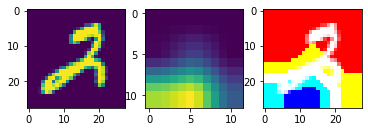

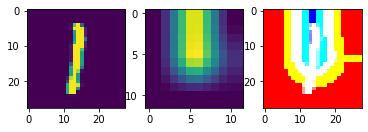

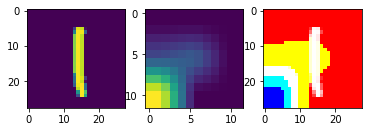

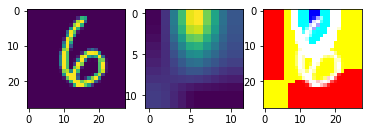

In [33]:
# Grad CAM 
Rows = 10
Columns = 3

for i in range(10):

    f, axarr = plt.subplots(1, 3)

    Array = Label[i]
    Class = np.where(Array == 1)[0][0]
    Output = Model.output[:, Class]
    LastLayer = Model.get_layer(index=5)
    Grads = K.gradients(Output, LastLayer.output)[0]
    PooledGrads = K.mean(Grads, axis=(0, 1, 2))
    Iterate = K.function([Model.input], [PooledGrads, LastLayer.output[0]])

    # Original Image
    Image = TrainData[i]
    axarr[0].imshow(Image.reshape(28, 28))

    PooledGradsValue, LastLayerValue = Iterate([Image.reshape(-1, 28, 28, 1)])
    for j in range(64):
        LastLayerValue[:, :, j] *= PooledGradsValue[j]
    
    # Heatmap 
    HeatMap = np.mean(LastLayerValue, axis=-1)
    HeatMap = np.maximum(HeatMap, 0)
    HeatMap /= np.max(HeatMap)
    axarr[1].imshow(cv2.resize(HeatMap, (12, 12)))


    # On Image
    HeatMap = cv2.resize(HeatMap, (Image.shape[1], Image.shape[0]))
    HeatMap = np.uint8(255 * HeatMap)
    HeatMap = cv2.applyColorMap(HeatMap, cv2.COLORMAP_JET)
    FinalImage = HeatMap * 0.4 + Image
    axarr[2].imshow(FinalImage)
    
plt.show()